![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example
In this notebook you perfrom iterative lensing reconstruction for two simulations, and on the full sky.
The simulations are created upon runtime inclusive of isotropic white noise, using the built-in FFP10 `sims` module.
At the end, we will plot the lensing potential estimate of both, the QE and iterative lensing reconstruction.

The configuration file is [here](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py), and you can freely change the parameters to your liking.

In [1]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


# Choose analysis
## QE lensing reconstruction
The following cell selects an exisiting configuration file, initialises dlensalot for a QE lensing reconstruction job, and runs lensing reconstruction

In [2]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_fullsky.py')
# fn = '/pscratch/sd/s/sebibel/dlensalot/lenscarf/sims_mwe/ffp10_lminB200_my_first_dlensalot_analysis/conf_mwe_fullsky.py'
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /pscratch/sd/s/sebibel/dlensalot/lenscarf/sims_mwe/ffp10_lminB200_my_first_dlensalot_analysis2/conf_mwe_fullsky.py
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 01-30 09:28:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 01-30 09:28:: root.store - Matching config file found. Resuming where I left off.
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 01-30 09:28:: lenscarf.lerepi.core.handler.log -

## iterative lensing reconstruction
The following cell repeats above, for the iterative case

In [ ]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe.py')
# fn = '/pscratch/sd/s/sebibel/dlensalot/lenscarf/sims_mwe/ffp10_lminB200_my_first_dlensalot_analysis/conf_mwe_fullsky.py'
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=False).job
ana_mwe.run()

CL[1]  18994092408985.168
GL[1] (before subtraction)  18994063198072.613
GL[1] (after subtraction)  -29210912.5546875


# Check your results
`get_plm(idx)` returns the spherical harmonics of the lensing potential estimate for simulation `idx`

INFO:: 01-30 09:28:: lenscarf.core.handler.log - get_plm(0) started
INFO:: 01-30 09:28:: lenscarf.core.handler.log - get_plm(0) finished


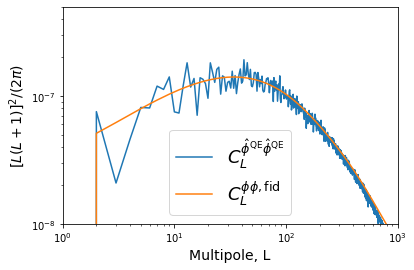

In [3]:
plm_QE = ana_mwe.get_plm(0)
# plm_MAP = ana_mwe.get_plm_it(ana_mwe.itmax)
ll = np.arange(0,4001,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
plt.plot(scale_factor*hp.alm2cl(plm_QE), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
# plt.plot(scale_factor*ana_mwe.get_plm(1, subtract_))
# plt.plot(hp.alm2cl(plm_MAP)*np.arange(0,4001,1)**4/(2*np.pi), label=r'$C_L^{\phi^{\rm MAP}\phi^{\rm MAP}}$')

plt.legend(fontsize=18)
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-8,5e-7)
plt.yscale('log')

# Other
## Check configuration
Let us look into the configuration file

In [3]:
print(ana_mwe.dlensalot_model.__str__())

## And how does the simulation data look like?

In [4]:
hp.mollview(ana_mwe.sims.get_sim_pmap(0)[0], title='E map')